# Исследование данных в области Гипертонии

## Описание данных

Для предсказания заболевания используются следующие признаки:

1. age: age in years
2. sex:
- 0 = Female
- 1 = Male
3. cp: Chest pain types
- 0 = Typical angina
- 1 = Atypical angina
- 2 = Non-angina pain
- 3 = Asymptomatic
4. trestbps: Resting blood pressure (mmHg)
- High blood pressure = 140 mmHg or above
5. chol: Serum cholestoral (mg/dL)
- Certain elements in the blood, including low-density lipoprotein (LDL), high-density lipoprotein (HDL) and triglycerides Calculation = HDL + LDL + 0.2 * triglycerides.Higher than 200 mg/dL is concerned
6. fbs: Fasting blood sugar (> 120 mg/dL)
- 0 = False
- 1 = True
7. restecg: Resting electrocardiographic results
- 0 = Normal
- 1 = Abnormal ST-T wave
- 2 = Showing probable or definite left ventricular hypertrophy
8. thalach: Maximum heart rate achieved (bpm)
9. exang: Exercise induced angina 
- 0 = Negative
- 1 = Positive
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: The slope of the peak exercise ST segment
- 0 = Upsloping
- 1 = Horizontal
- 2 = Downsloping
12. ca: Number of major vessels (0-3) colored by fluoroscopy. The colored blood vessels are passing through. There is a clot if the blood vessel is not colored
13. thal: Thallium scintigraphy
- 3 = Normal
- 6 = Fixed defect
- 7 = Reversable defect
14. target: Whether the patient has hypertension
- 0 = Negative
- 1 = Positive

## Изучение датасета

Импортируем необхожимые для работы библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from optuna.samplers import TPESampler, RandomSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from optuna.integration import CatBoostPruningCallback
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Сохраним наш датасет в перменной df, откроем и взглянем на первые 5 строк

In [2]:
df = pd.read_csv('hypertension_data.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,57.0,1.0,3,145,233,1,0,150,0,2.3,0,0,1,1
1,64.0,0.0,2,130,250,0,1,187,0,3.5,0,0,2,1
2,52.0,1.0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56.0,0.0,1,120,236,0,1,178,0,0.8,2,0,2,1
4,66.0,0.0,0,120,354,0,1,163,1,0.6,2,0,2,1


Проверим датасет на наличие пропусков

In [3]:
df.isna().sum()

age          0
sex         25
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
target       0
dtype: int64

Пропусков всего 25. Удалим строки с пропущенными значениями

In [4]:
df=df.dropna()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26058 entries, 0 to 26082
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       26058 non-null  float64
 1   sex       26058 non-null  float64
 2   cp        26058 non-null  int64  
 3   trestbps  26058 non-null  int64  
 4   chol      26058 non-null  int64  
 5   fbs       26058 non-null  int64  
 6   restecg   26058 non-null  int64  
 7   thalach   26058 non-null  int64  
 8   exang     26058 non-null  int64  
 9   oldpeak   26058 non-null  float64
 10  slope     26058 non-null  int64  
 11  ca        26058 non-null  int64  
 12  thal      26058 non-null  int64  
 13  target    26058 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 3.0 MB


Пропуски отсутствуют. Столбцы age, sex переведем в формат int

In [6]:
df[['age', 'sex']] = df[['age', 'sex']].astype('int')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26058 entries, 0 to 26082
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       26058 non-null  int32  
 1   sex       26058 non-null  int32  
 2   cp        26058 non-null  int64  
 3   trestbps  26058 non-null  int64  
 4   chol      26058 non-null  int64  
 5   fbs       26058 non-null  int64  
 6   restecg   26058 non-null  int64  
 7   thalach   26058 non-null  int64  
 8   exang     26058 non-null  int64  
 9   oldpeak   26058 non-null  float64
 10  slope     26058 non-null  int64  
 11  ca        26058 non-null  int64  
 12  thal      26058 non-null  int64  
 13  target    26058 non-null  int64  
dtypes: float64(1), int32(2), int64(11)
memory usage: 2.8 MB


In [8]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,26058.000000,26058.00000,26058.000000,26058.000000,26058.000000,26058.000000,26058.000000,26058.000000,26058.000000,26058.000000,26058.000000,26058.000000,26058.000000,26058.000000
mean,55.655730,0.50000,0.956635,131.590682,246.286591,0.149896,0.526057,149.643181,0.326886,1.039742,1.399724,0.720623,2.319057,0.547778
std,15.190407,0.50001,1.022467,17.597086,51.651701,0.356977,0.525688,22.865871,0.469084,1.165673,0.616529,1.011317,0.604868,0.497722
min,11.000000,0.00000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,0.00000,0.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,0.50000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,67.000000,1.00000,2.000000,140.000000,275.000000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,98.000000,1.00000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Проверим целевой признак на предмет баланса признаков

In [9]:
df['target'].value_counts()

1    14274
0    11784
Name: target, dtype: int64

(-1.25, 1.25, -1.25, 1.25)

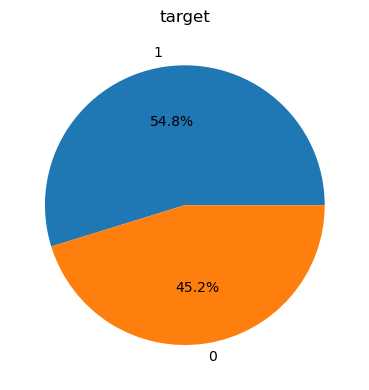

In [10]:
df.target.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4, 4))
plt.title('target')
plt.tight_layout()
plt.axis('off')

Мы видим допустимое соотношение больных к здоровым, дисбаланс отсутствует

## Предобработка данных

Разберем каждый столбец по отдельностии исследуем на предмет выбросов

### 1. age (возраст)

In [11]:
df['age'].describe()

count    26058.000000
mean        55.655730
std         15.190407
min         11.000000
25%         44.000000
50%         56.000000
75%         67.000000
max         98.000000
Name: age, dtype: float64

<Axes: >

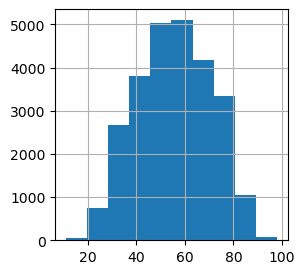

In [12]:
df['age'].hist(figsize=(3, 3))

### 2. sex (пол)

In [13]:
df['sex'].value_counts()

1    13029
0    13029
Name: sex, dtype: int64

(-1.25, 1.25, -1.25, 1.25)

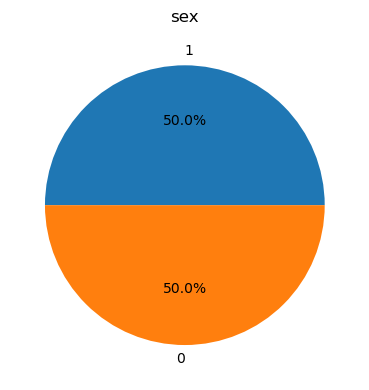

In [14]:
df.sex.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4, 4))
plt.title('sex')
plt.tight_layout()
plt.axis('off')

### 3. cp (Тип боли в груди)

In [15]:
df['cp'].value_counts()

0    12314
2     7392
1     4456
3     1896
Name: cp, dtype: int64

(-1.25, 1.25, -1.25, 1.25)

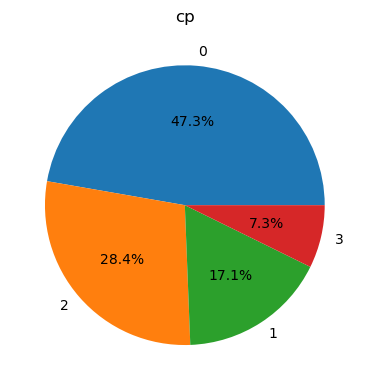

In [16]:
df.cp.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize = (4, 4))
plt.title('cp')
plt.tight_layout()
plt.axis('off')

### 4. trestbps (кровяное давление в  состоянии покоя)

<Axes: >

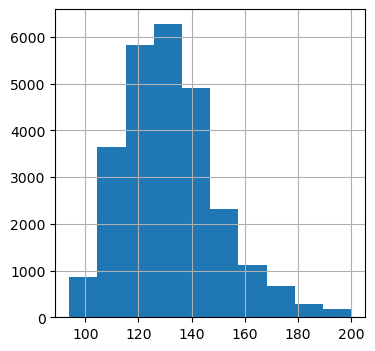

In [17]:
df['trestbps'].hist(figsize=(4, 4))

### 5. chol (уровень холестерина в сыворотке крови (мг/дл))

<Axes: >

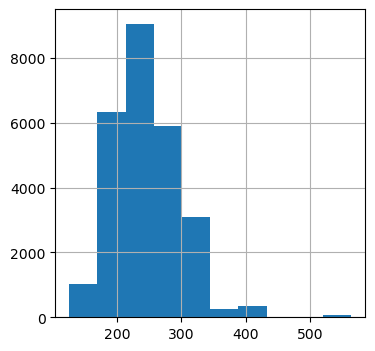

In [18]:
df['chol'].hist(figsize=(4, 4))

In [19]:
df['chol'].describe()

count    26058.000000
mean       246.286591
std         51.651701
min        126.000000
25%        211.000000
50%        240.000000
75%        275.000000
max        564.000000
Name: chol, dtype: float64

In [20]:
df[df['chol'] > 350]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
4,66,0,0,120,354,0,1,163,1,0.6,2,0,2,1
28,34,1,2,140,417,1,0,157,0,0.8,2,1,2,1
39,67,0,2,160,360,0,0,151,0,0.8,2,0,2,1
85,54,0,2,115,564,0,0,160,0,1.6,1,0,3,1
96,60,0,0,140,394,0,0,157,0,1.2,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25976,75,0,2,140,417,1,0,157,0,0.8,2,1,2,1
25985,72,1,0,140,394,0,0,157,0,1.2,1,0,2,1
26019,73,1,0,150,407,0,0,154,0,4.0,1,3,3,0
26049,75,0,2,160,360,0,0,151,0,0.8,2,0,2,1


In [21]:
#df = df[df['chol'] <= 350]
#df.info()

### 6. fbs (Уровень сахара в крови натощак(> 120 mg/dL))

In [22]:
df['fbs'].describe()

count    26058.000000
mean         0.149896
std          0.356977
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: fbs, dtype: float64

(-1.25, 1.25, -1.25, 1.25)

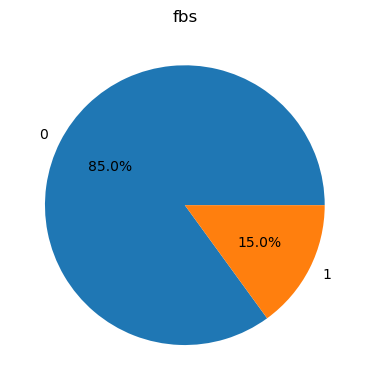

In [23]:
df.fbs.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('fbs')
plt.tight_layout()
plt.axis('off')

### 7. restecg (Результаты электрокардиографии в состоянии покоя(0-Обычный; 1-Аномальная волна ST-T; 2-Наличие вероятной или определенной гипертрофии левого желудочка))

In [24]:
df['restecg'].value_counts()

1    13004
0    12702
2      352
Name: restecg, dtype: int64

(-1.25, 1.25, -1.25, 1.25)

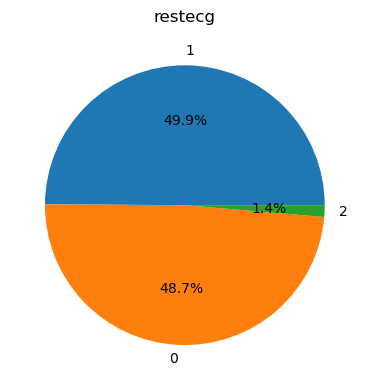

In [25]:
df.restecg.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('restecg')
plt.tight_layout()
plt.axis('off')

### 8. thalach (Достигнутая максимальная частота сердечных сокращений (ударов в минуту))

In [26]:
df['thalach'].describe()

count    26058.000000
mean       149.643181
std         22.865871
min         71.000000
25%        133.000000
50%        153.000000
75%        166.000000
max        202.000000
Name: thalach, dtype: float64

<Axes: >

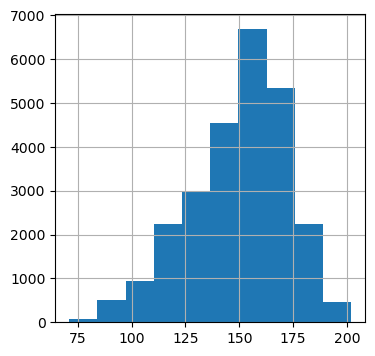

In [27]:
df['thalach'].hist(figsize=(4,4))

### 9. exang (Стенокардия, вызванная физической нагрузкой (0-Отрицательный, 1-Положительный)

In [28]:
df['exang'].value_counts()

0    17540
1     8518
Name: exang, dtype: int64

(-1.25, 1.25, -1.25, 1.25)

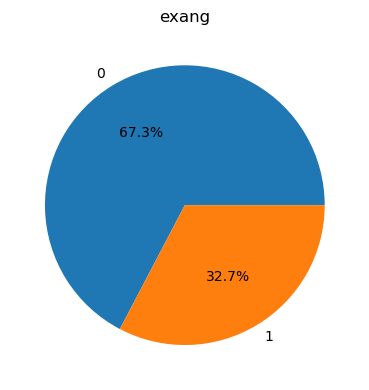

In [29]:
df.exang.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('exang')
plt.tight_layout()
plt.axis('off')

### 10. oldpeak (депрессия ST, вызванная физической нагрузкой по сравнению с отдыхом)

In [30]:
df['oldpeak'].describe()

count    26058.000000
mean         1.039742
std          1.165673
min          0.000000
25%          0.000000
50%          0.800000
75%          1.600000
max          6.200000
Name: oldpeak, dtype: float64

<Axes: >

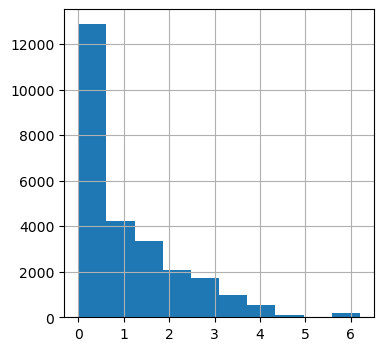

In [31]:
df['oldpeak'].hist(figsize=(4,4))

### 11. slope (наклон сегмента ST пикового упражнения - 0-Подъем по склону, 1-Горизонтальный, 2-Нисходящий уклон)

In [32]:
df['slope'].value_counts()

2    12242
1    11990
0     1826
Name: slope, dtype: int64

(-1.25, 1.25, -1.25, 1.25)

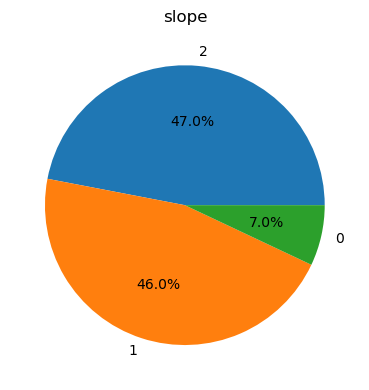

In [33]:
df.slope.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('slope')
plt.tight_layout()
plt.axis('off')

### 12. ca (количество крупных сосудов (0-3), окрашенная при рентгеноскопии. Через них проходят окрашенные кровеносные сосуды. Если кровеносный сосуд не окрашен, образуется тромб)

In [34]:
df['ca'].value_counts()

0    15146
1     5514
2     3298
3     1732
4      368
Name: ca, dtype: int64

<Axes: >

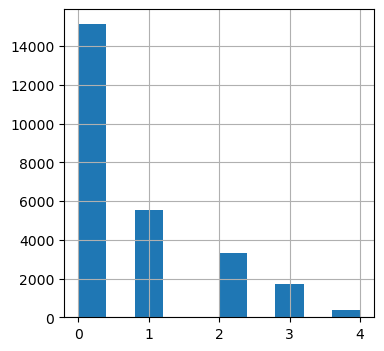

In [35]:
df['ca'].hist(figsize=(4,4))

### 13. thal (Сцинтиграфия таллия - 3-Нормальный, 6-Исправленный дефект, 7-Обратимый дефект)

In [36]:
df['thal'].value_counts()

2    14334
3    10096
1     1474
0      154
Name: thal, dtype: int64

<Axes: >

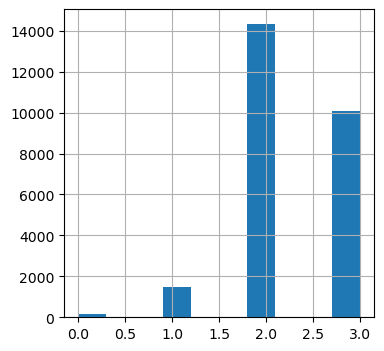

In [37]:
df['thal'].hist(figsize=(4,4))

### 14. target (Есть ли у пациента гипертоническая болезнь - 0-Отрицательный, 1-Положительный)

In [38]:
df['target'].value_counts()

1    14274
0    11784
Name: target, dtype: int64

(-1.25, 1.25, -1.25, 1.25)

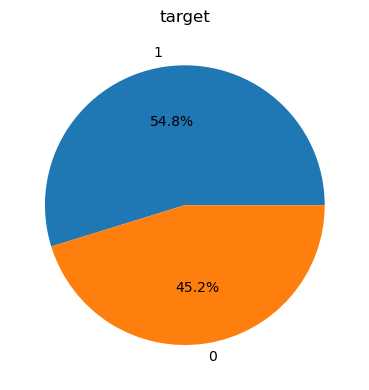

In [39]:
df.target.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('target')
plt.tight_layout()
plt.axis('off')

## Обучение моделей

Определим признаки и целевой признак

In [40]:
X = df.drop(['target'], axis=1)
y = df['target']

Разделим датасет на тренировочную и тестовую выборки

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [42]:
X_test.shape

(7818, 13)

Напишем функцию для быстрого получения показателей работы модели

In [43]:
def checkstat (model, X_train, y_train): 
    model.fit(X_train, y_train)
    predicted_test=model.predict(X_test)
    print('Accuracy :', accuracy_score(y_test, predicted_test))
    print("F1:", f1_score(y_test, predicted_test))
    print('recall:', recall_score(y_test, predicted_test))
    print('precision:', precision_score(y_test, predicted_test))
    cm = confusion_matrix(y_test, predicted_test, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
    disp.plot()
    plt.show()

### 1.RandomForestClassifier

In [44]:
model_rfc = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=5, class_weight='balanced')
scores = cross_val_score(model_rfc, X, y, cv = 5, scoring = 'accuracy')
scores

array([0.93092863, 0.92689946, 0.91730622, 0.93801574, 0.93072347])

Accuracy : 0.9364287541570734
F1: 0.943784639746635
recall: 0.9691056910569106
precision: 0.9197530864197531


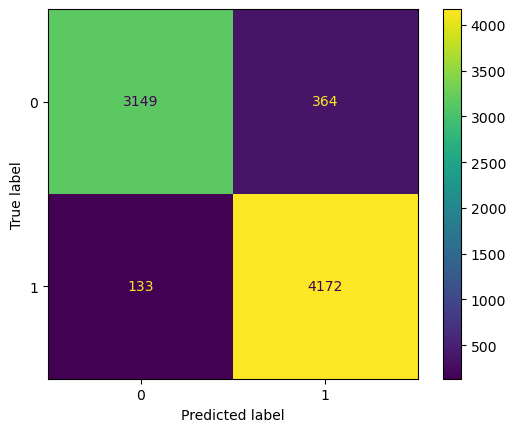

In [45]:
checkstat(model_rfc, X_train, y_train)

##  2.DecisionTreeClassifier

In [46]:
model_dtc = DecisionTreeClassifier(random_state=42, max_depth=5)
scores = cross_val_score(model_dtc, X, y, cv = 5, scoring = 'accuracy')
scores

array([0.926132  , 0.92555641, 0.92843438, 0.92515832, 0.92554212])

Accuracy : 0.9277308774622666
F1: 0.9367796799820969
recall: 0.9723577235772358
precision: 0.903713298791019


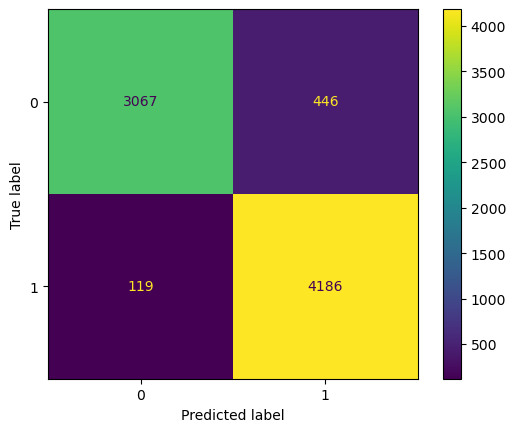

In [47]:
checkstat(model_dtc, X_train, y_train)

## 3.CatBoost

In [48]:
train_pool = Pool (
    X_train,
    y_train

)
test_pool = Pool (
    X_test,
   y_test
)

In [49]:
EVAL = 'TotalF1'

In [50]:
def objective(trial):

   # это гиперпараметры, которые будем проверять. 
    param = {
       # suggest_int и suggest_float - непрерывные переменные. выбирает из диапазона от-до. 
       # можно ставить шаг (как стоит у регуляризации), чтоб он не тыкался +- сотые :)
        'learning_rate':trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'l2_leaf_reg':trial.suggest_float('l2_leaf_reg', 2.0, 20.0, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 500),
        'depth': trial.suggest_int('depth', 3, 12),
       
       # suggest_categorical - выбор из списка.
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Lossguide', 'Depthwise']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']), 
      
    }
    # эти гиперпараметры тоже подбираем, но отдельно, в зависимости от выбранного bootstrap_type
   # если делать одним куском, то будет падать
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 0.99)
    cat_model = CatBoostClassifier(**param, 
                                   iterations=3000,
                                   random_state=12345,
                                   eval_metric=EVAL,
                                   verbose=0, 
                                   leaf_estimation_method='Newton',
                                #   task_type='GPU',
                                   early_stopping_rounds=120,  
                               #   custom_metric=['AUC', 'NormalizedGini'],
                                   )
    
   # это интеграция. прунер - фиговинка, которая сама прервет эксперимент, если ей что-то не понравится
   # не особо давно добавили и иногда глючит. но с ним лучше
    pruning_callback = CatBoostPruningCallback(trial, EVAL)
   
    cat_model.fit(train_pool, eval_set=test_pool)
   
    pruning_callback.check_pruned()
   
   # результат в процессе оно не печатает, хоть так.
    print(param)
    print(cat_model.best_score_)
    print('________________')
    return cat_model.best_score_['validation'][EVAL]

In [51]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# семплер - что-то типа способа подбора параметров. 
# первые раз 20 лучше запустить RandomSampler(), он работает по принципу RandomizedSearchCV из sklearn
# помогает приблизительно оценить интервалы параметров. потом в функции оптимизации порезать :)
# сам TPESampler рекомендуют запускать под сотню раз. 
sampler = TPESampler(seed=12345) 
# объявление процесса подбора
# для TPESampler используют прунер HyperbandPruner()
# для RandomSampler - прунер MedianPruner()
study = optuna.create_study(study_name="catboost", 
                            direction="maximize",
                            pruner=optuna.pruners.HyperbandPruner(),
                            sampler=sampler)
# study тут создается новый, а вообще можно его сохранять/загружать, 
# если хочется продолжить подбор на том же наборе данных

In [52]:
# это уже запуск попыток. n_trials количество. можно поставить время timeout
study.optimize(objective, n_trials=5)

{'learning_rate': 0.08503859825373385, 'l2_leaf_reg': 8.0, 'min_data_in_leaf': 100, 'depth': 5, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6816771850580444}
{'learn': {'Logloss': 0.002297646504375098, 'TotalF1': 1.0}, 'validation': {'Logloss': 0.0023456038200775375, 'TotalF1': 1.0}}
________________
{'learning_rate': 0.05593901428206581, 'l2_leaf_reg': 20.0, 'min_data_in_leaf': 14, 'depth': 4, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7440799587587585}
{'learn': {'Logloss': 0.013497596173491276, 'TotalF1': 1.0}, 'validation': {'Logloss': 0.013813455434183953, 'TotalF1': 1.0}}
________________
{'learning_rate': 0.043901092488902525, 'l2_leaf_reg': 15.0, 'min_data_in_leaf': 239, 'depth': 6, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.25211368943526663}
{'learn': {'Logloss': 0.008323397923501953, 'TotalF1': 1.0}, 'validation': {'Logloss': 0.008507627618490016, 'TotalF1': 1.0}}
________________
{'l

In [53]:
# лучшая метрика
study.best_trial.value
# гиперпараметры, для которых она достигнута
study.best_trial.params

{'learning_rate': 0.08503859825373385,
 'l2_leaf_reg': 8.0,
 'min_data_in_leaf': 100,
 'depth': 5,
 'grow_policy': 'Depthwise',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.6816771850580444}

In [54]:
catboost = CatBoostClassifier(random_state=12345, silent=True)
catboost_params = {
    'learning_rate': 0.08503859825373385,
     'l2_leaf_reg': 8.0,
     'min_data_in_leaf': 100,
     'depth': 5,
     'grow_policy': 'Depthwise',
     'bootstrap_type': 'Bernoulli',
     'bagging_temperature': 0.6816771850580444
}

catboost.fit(train_pool, eval_set=test_pool) 
catboost.best_score_

{'learn': {'Logloss': 0.0011922981132540787},
 'validation': {'Logloss': 0.001229230725397165}}

Accuracy : 1.0
F1: 1.0
recall: 1.0
precision: 1.0


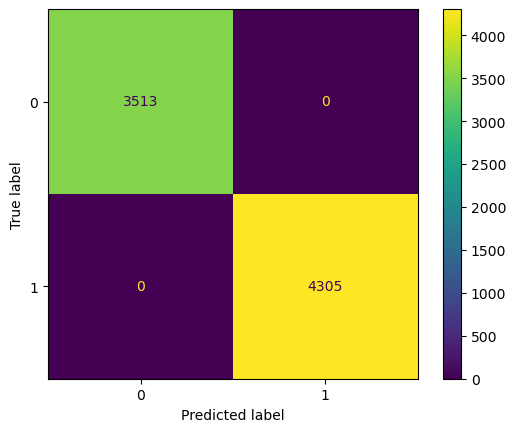

In [55]:
checkstat(catboost, X_train, y_train)

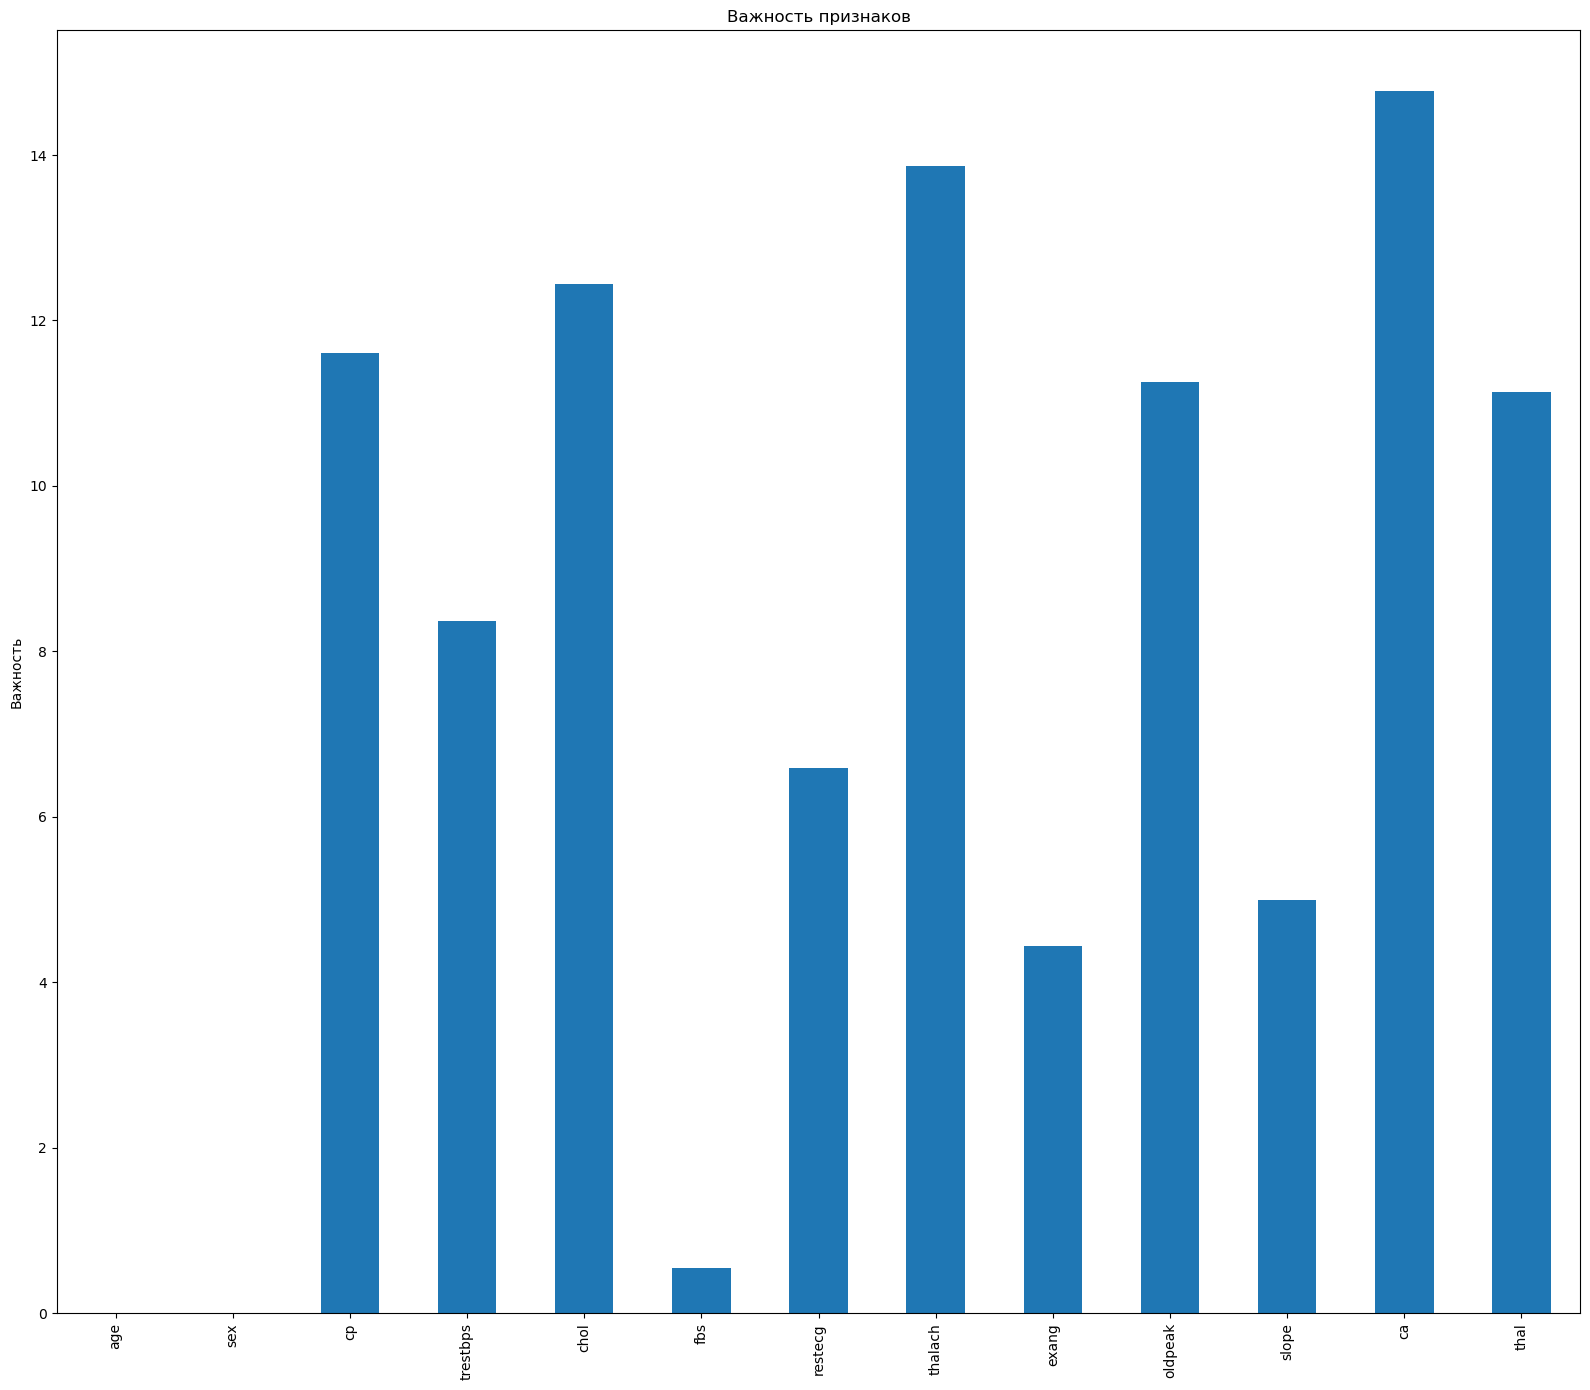

In [56]:
f_imp = pd.Series(catboost.feature_importances_,
                         df.drop(['target'], axis=1).columns)

fig, ax = plt.subplots(figsize=(16,14))
f_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

## 4.LGBM

In [57]:
model_lgbm = LGBMClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_lgbm, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)', n_scores)

Accuracy: %.3f (%.3f) [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


Accuracy : 1.0
F1: 1.0
recall: 1.0
precision: 1.0


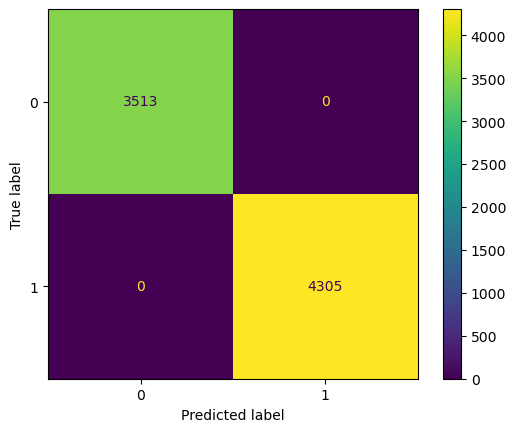

In [58]:
checkstat(model_lgbm, X_train, y_train)

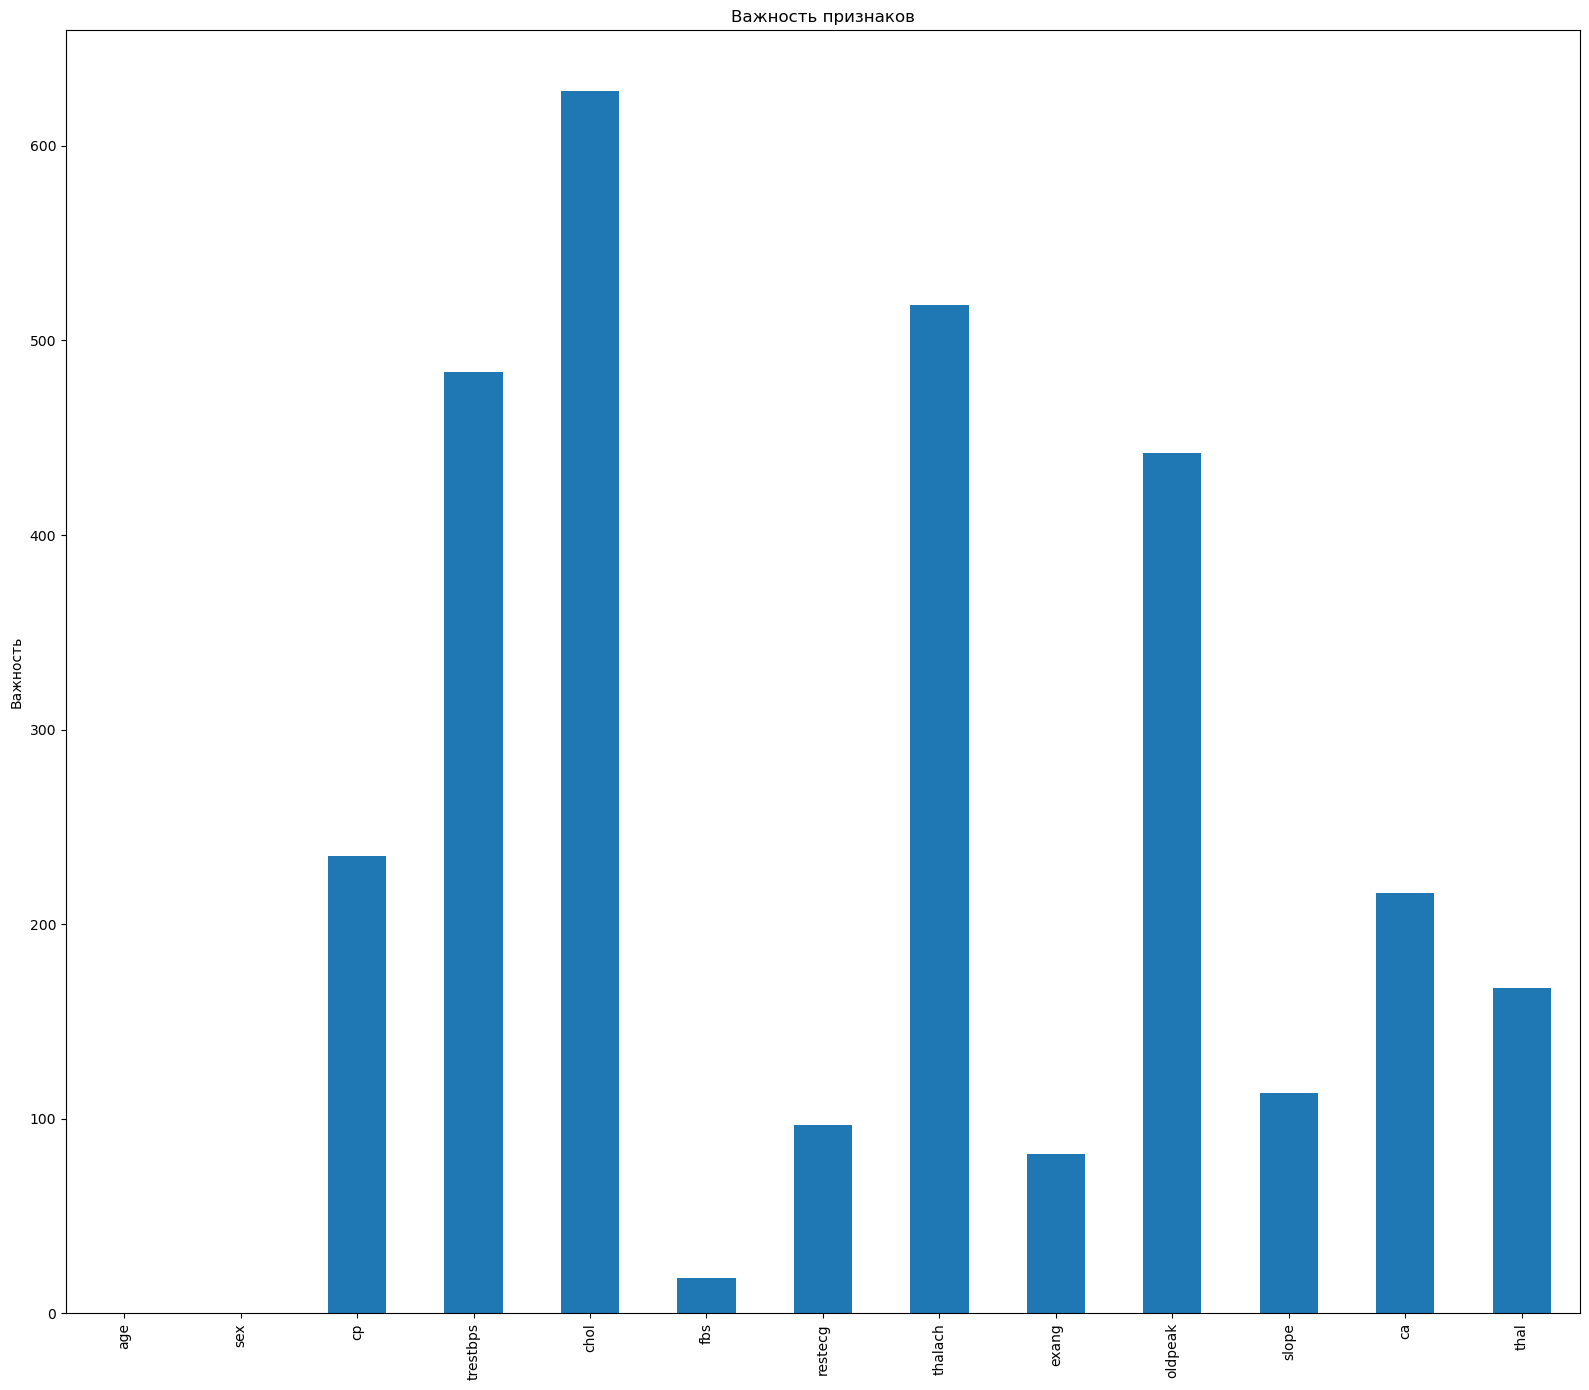

In [59]:
f_imp = pd.Series(model_lgbm.feature_importances_,
                         df.drop(['target'], axis=1).columns)

fig, ax = plt.subplots(figsize=(16,14))
f_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

## 5.KNeighborsClassifier

In [60]:
model_KNN = KNeighborsClassifier(n_neighbors = 5)
scores = cross_val_score(model_KNN, X_train, y_train, cv = 5, scoring = 'accuracy')
scores.mean()

0.9951206140350877

Accuracy : 0.9966743412637503
F1: 0.9969809568044589
recall: 0.997212543554007
precision: 0.9967494775946134


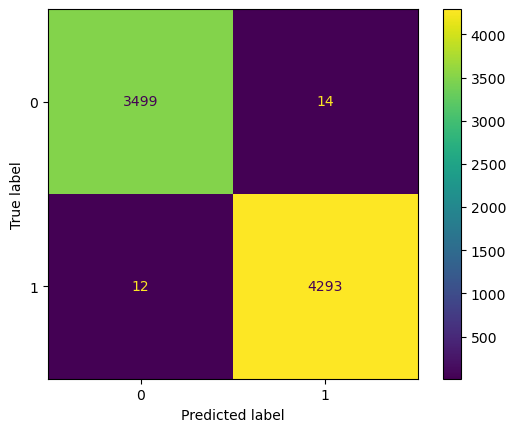

In [61]:
checkstat(model_KNN, X_train, y_train)

# Вывод

Проведя предобработку датасета, проверив на наличие пропусков, дубликатов и выбросов, проверив корреляцию признаков мы пришли к выводу, что большая часть признаков имеют отрицательную корреляцию. Отрицательная корреляция может быть, если использовать только признаки с положительной корреляцией, то останется слишком мало признаков. Было принято решение оставить признаки с более высокой корреляцией. 
Обучив несколько моделей, подобрав гиперпраметры, мы сделали вывод, что наилучший результат показали модели CatBoostClassifier и LightGBM.